### DATA PREPARATION

Importing necssary libraries

In [66]:
import pandas as pd
import numpy as np

import df_helper as dfh

df_helper = dfh.df_helper()

Loading the data

In [67]:

admissions = pd.read_csv('data/admissions.csv')
omr = pd.read_csv('data/omr.csv')
diagnoses = pd.read_csv('data/diagnoses_icd.csv')
patients=pd.read_csv("data/patients.csv")
diagnoses2=pd.read_csv("data/d_icd_diagnoses.csv")
prescriptions=pd.read_csv("data/prescriptions.csv")

The first step was to view the data.

In [68]:
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,P41R5N,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,NaN,0
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,P233F6,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2134-08-17 16:24:00,2134-08-18 03:15:00,0
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,1
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,P07HDB,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,0


In [69]:
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136


In [70]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


In [71]:
prescriptions.head()

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,...,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10027602,28166872,27168639,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Fentanyl Citrate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10027602,28166872,40720238,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Fentanyl Citrate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10027602,28166872,62845687,NaN,NaN,NaN,2201-10-31 12:00:00,NaN,MAIN,Lorazepam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10027602,28166872,24340150,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Midazolam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10027602,28166872,14435820,NaN,NaN,NaN,2201-10-30 12:00:00,NaN,MAIN,Midazolam,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10035185,22580999,3,4139,9
1,10035185,22580999,10,V707,9
2,10035185,22580999,1,41401,9
3,10035185,22580999,9,3899,9
4,10035185,22580999,11,V8532,9


In [73]:
diagnoses2.head()

,icd_code,icd_version,long_title
0,0090,9,"Infectious colitis, enteritis, and gastroenter..."
1,01160,9,"Tuberculous pneumonia [any form], unspecified"
2,01186,9,"Other specified pulmonary tuberculosis, tuberc..."
3,01200,9,"Tuberculous pleurisy, unspecified"
4,01236,9,"Tuberculous laryngitis, tubercle bacilli not f..."


In [74]:
pivot_omr = omr.pivot_table(
    index=['subject_id'], 
    columns='result_name', 
    values='result_value', aggfunc="last"
).reset_index()

df_helper.drop_columns(pivot_omr,[
    "Blood Pressure Lying", 
    "Blood Pressure Sitting", 
    "Blood Pressure Standing (1 min)", 
    "Blood Pressure Standing (3 mins)"
])

df_helper.rename_columns(pivot_omr, {
    "BMI (kg/m2)":"bmi",
    "Blood Pressure":"blood pressure",
    "Height (Inches)":"height",
    "Weight (Lbs)":"weight"
})

pivot_omr = df_helper.convert_inches_to_meters(pivot_omr, "height", 2)
pivot_omr = df_helper.convert_lbs_to_kg(pivot_omr, "weight", 2)

# Apply the function and expand into separate columns
pivot_omr[['bp_systolic', 'bp_diastolic']] = pivot_omr['blood pressure'].apply(preprocess_blood_pressure)
df_helper.drop_columns(
    pivot_omr,[
        "blood pressure",
    ]
)

pivot_omr

NameError: name 'preprocess_blood_pressure' is not defined

In [ ]:
#defining t a function to define the base of all dataframes
base_df = pd.merge(admissions, pivot_omr, how="left", on="subject_id")
df_helper.drop_columns(
    base_df,[
        "admit_provider_id",
        "discharge_location",
        "hospital_expire_flag",
        "edregtime",
        "edouttime",
])
filtered_df=df_helper.column_subset(
    patients,[
        "subject_id",
        "gender",
        "anchor_age"
])
base_df=pd.merge(filtered_df, base_df, on="subject_id", how="right")
#rename anchor_age to age
df_helper.rename_column(base_df, "anchor_age", "age")
base_df

,subject_id,gender,age,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight
0,10004235,M,47,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
1,10009628,M,58,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,?,MARRIED,HISPANIC/LATINO - PUERTO RICAN,NaN,108/70,NaN,NaN
2,10018081,M,79,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,MARRIED,WHITE,28.5,140/60,1.73,85.00
3,10006053,M,52,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,NaN,UNKNOWN,NaN,NaN,NaN,NaN
4,10031404,F,82,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Other,ENGLISH,WIDOWED,WHITE,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10038992,M,70,24745425,2187-07-29 01:05:00,2187-08-03 17:02:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,MARRIED,WHITE,31.9,140/85,1.78,101.00
271,10008287,F,43,22168393,2145-09-28 01:17:00,2145-10-02 13:35:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Other,ENGLISH,SINGLE,WHITE,NaN,96/60,NaN,75.34
272,10022880,M,66,27708593,2177-03-12 07:15:00,2177-03-19 14:25:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,MARRIED,WHITE,29.3,142/84,1.85,95.25
273,10004457,M,65,23251352,2141-12-17 11:00:00,2141-12-21 15:56:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,SINGLE,OTHER,24.4,162/89,1.77,76.11


In [ ]:
merged_diagnoses= pd.merge(diagnoses, diagnoses2, on=['icd_code', 'icd_version'], how='left')
merged_diagnoses.drop(["icd_code", "icd_version","seq_num"],axis=1,inplace=True)
#rename long_title column to diagnosis
merged_diagnoses.rename(columns={"long_title":"diagnosis"}, inplace=True)
#merge diagnoseswith the pivot_omr dataframe using the subject_id column
merged_diagnoses = pd.merge(merged_diagnoses, base_df, on="subject_id", how="right")
merged_diagnoses.drop("hadm_id_y", axis=1, inplace=True)
#rename hadm_id_x to hadm_id
merged_diagnoses.rename(columns={"hadm_id_x":"hadm_id"}, inplace=True)
merged_diagnoses


,subject_id,hadm_id,diagnosis,gender,age,admittime,dischtime,deathtime,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight
0,10004235,25970245,Acute and chronic cholecystitis,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
1,10004235,25970245,"Body Mass Index 35.0-35.9, adult",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
2,10004235,25970245,Other specified cardiac dysrhythmias,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
3,10004235,25970245,"Obesity, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
4,10004235,25970245,"Gout, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31228,10004457,23251352,Personal history of malignant neoplasm of pros...,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11
31229,10004457,23251352,Multiple involvement of mitral and aortic valves,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11
31230,10004457,23251352,"Asthma, unspecified type, unspecified",M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11
31231,10004457,23251352,Chronic total occlusion of coronary artery,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,NaN,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11


In [ ]:
death_df=admissions[["subject_id","hadm_id","deathtime"]].copy()
death_df["died"]=death_df["deathtime"].isna()==False
death_df.drop("deathtime",axis=1,inplace=True)
death_df.head()

,subject_id,hadm_id,died
0,10004235,24181354,False
1,10009628,25926192,False
2,10018081,23983182,False
3,10006053,22942076,True
4,10031404,21606243,False


In [ ]:
#Merge the death df with the merged diagnoses dataframe

diagnoses_death_df=pd.merge(merged_diagnoses, death_df, on=["subject_id","hadm_id"], how="left")
diagnoses_death_df["died"].fillna(False, inplace=True)
diagnoses_death_df.drop("deathtime",axis=1, inplace=True)
diagnoses_death_df

C:\Users\Calvine Mugunda\AppData\Local\Temp\ipykernel_12332\595925564.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diagnoses_death_df["died"].fillna(False, inplace=True)


,subject_id,hadm_id,diagnosis,gender,age,admittime,dischtime,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died
0,10004235,25970245,Acute and chronic cholecystitis,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
1,10004235,25970245,"Body Mass Index 35.0-35.9, adult",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
2,10004235,25970245,Other specified cardiac dysrhythmias,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
3,10004235,25970245,"Obesity, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
4,10004235,25970245,"Gout, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31228,10004457,23251352,Personal history of malignant neoplasm of pros...,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31229,10004457,23251352,Multiple involvement of mitral and aortic valves,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31230,10004457,23251352,"Asthma, unspecified type, unspecified",M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31231,10004457,23251352,Chronic total occlusion of coronary artery,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False


In [ ]:
# merging the filtered_df dataframe with the diagnoses_death_df dataframe using the subject_id column as the key. 
filtered_df=patients[["subject_id","anchor_age"]]
diagnoses_death_df=pd.merge(filtered_df, diagnoses_death_df, on="subject_id", how="right")
#rename anchor_age to age

diagnoses_death_df.rename(columns={"anchor_age":"age"}, inplace=True)
diagnoses_death_df

,subject_id,age,hadm_id,diagnosis,gender,age,admittime,dischtime,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died
0,10004235,47,25970245,Acute and chronic cholecystitis,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
1,10004235,47,25970245,"Body Mass Index 35.0-35.9, adult",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
2,10004235,47,25970245,Other specified cardiac dysrhythmias,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
3,10004235,47,25970245,"Obesity, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
4,10004235,47,25970245,"Gout, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31228,10004457,65,23251352,Personal history of malignant neoplasm of pros...,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31229,10004457,65,23251352,Multiple involvement of mitral and aortic valves,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31230,10004457,65,23251352,"Asthma, unspecified type, unspecified",M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False
31231,10004457,65,23251352,Chronic total occlusion of coronary artery,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False


In [ ]:

length_of_stay_df =diagnoses_death_df.copy()

length_of_stay_df["admittime"]=pd.to_datetime(length_of_stay_df["admittime"])
length_of_stay_df["dischtime"]=pd.to_datetime(length_of_stay_df["dischtime"])

#calculate the length of stay in days

length_of_stay_df["length_of_stay"]=length_of_stay_df["dischtime"]-length_of_stay_df["admittime"]
length_of_stay_df["length_of_stay"]=length_of_stay_df["length_of_stay"].dt.days

length_of_stay_df



,subject_id,age,hadm_id,diagnosis,gender,age,admittime,dischtime,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died,length_of_stay
0,10004235,47,25970245,Acute and chronic cholecystitis,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False,8
1,10004235,47,25970245,"Body Mass Index 35.0-35.9, adult",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False,8
2,10004235,47,25970245,Other specified cardiac dysrhythmias,M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False,8
3,10004235,47,25970245,"Obesity, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False,8
4,10004235,47,25970245,"Gout, unspecified",M,47,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,TRANSFER FROM HOSPITAL,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,34.9,138/101,1.83,116.57,False,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31228,10004457,65,23251352,Personal history of malignant neoplasm of pros...,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False,2
31229,10004457,65,23251352,Multiple involvement of mitral and aortic valves,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False,2
31230,10004457,65,23251352,"Asthma, unspecified type, unspecified",M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False,2
31231,10004457,65,23251352,Chronic total occlusion of coronary artery,M,65,2147-12-19 00:00:00,2147-12-21 16:10:00,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,Medicare,ENGLISH,DIVORCED,WHITE,24.4,162/89,1.77,76.11,False,2


In [ ]:
#merging specific features from the prescriptions csv
prescriptions_df=length_of_stay_df.copy()
filtered_readmission_df =prescriptions[["subject_id","hadm_id","drug_type","drug"]]
prescriptions_df=pd.merge(filtered_readmission_df, prescriptions_df, on=["subject_id","hadm_id"],how="left")
#prescriptions.drop("gender_y", axis=1, inplace=True)
#rename gender_x to gender
prescriptions_df.rename(columns={"gender_x":"gender"}, inplace=True)
#dropping duplicates from the readmission_df
prescriptions_df.drop_duplicates(inplace=True)
prescriptions_df


,subject_id,hadm_id,drug_type,drug,age,diagnosis,gender,age,admittime,dischtime,...,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died,length_of_stay
0,10027602,28166872,MAIN,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
1,10027602,28166872,MAIN,Fentanyl Citrate,71,Acute respiratory failure,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
2,10027602,28166872,MAIN,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
3,10027602,28166872,MAIN,Fentanyl Citrate,71,Solitary pulmonary nodule,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
4,10027602,28166872,MAIN,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362332,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,"Constipation, unspecified",M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362333,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,"Hematuria, unspecified",M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362334,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,Obstructive sleep apnea (adult) (pediatric),M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362335,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,Long term (current) use of anticoagulants,M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3


In [ ]:
#Useful for TimeSeries
df=admissions.copy()
df.admittime = pd.to_datetime(df.admittime)   
df.dischtime = pd.to_datetime(df.dischtime)

df1 = df.groupby([df.admittime.dt.year, df.admittime.dt.month]).count().rename_axis(['year', 'month'])['admittime'].reset_index(name='Entries')

df1

,year,month,Entries
0,2110,4,1
1,2110,11,1
2,2111,1,1
3,2111,11,1
4,2112,9,1
...,...,...,...
217,2201,2,1
218,2201,3,1
219,2201,7,1
220,2201,10,1


In [ ]:
admissions.duplicated().value_counts()

False    275
Name: count, dtype: int64

In [ ]:
#Calculating the number of readmissions for each subject_id using a readmission threshold of 30 days
readmissions_df= admissions[["subject_id","hadm_id","admittime","dischtime"]].copy()


readmissions_df['admittime'] = pd.to_datetime(readmissions_df['admittime'])
readmissions_df['dischtime'] = pd.to_datetime(readmissions_df['dischtime'])

# Assuming df is your dataframe and readmission_threshold is defined
readmission_threshold = pd.Timedelta(days=30)

# Sort by subject_id, admittime
readmissions_df = readmissions_df.sort_values(by=['subject_id', 'admittime'])

# Calculate the time to next admission and determine if it's a readmission
readmissions_df['next_admittime'] = readmissions_df.groupby('subject_id')['admittime'].shift(-1)
readmissions_df['readmission_time'] = readmissions_df['next_admittime'] - readmissions_df['dischtime']
readmissions_df['is_readmission'] = (readmissions_df['readmission_time'] <= readmission_threshold) & (readmissions_df['readmission_time'] > pd.Timedelta(days=0))

# Calculate readmissions per patient
readmissions_df['readmissions'] = readmissions_df.groupby('subject_id')['is_readmission'].cumsum()

#merge readmission_df with base_df
base_copy = base_df.copy()
base_copy.drop(["admittime", "dischtime"], axis=1, inplace=True)
readmissions_df = pd.merge(readmissions_df, base_copy, on=['subject_id', 'hadm_id'], how='left')
readmissions_df

,subject_id,hadm_id,admittime,dischtime,next_admittime,readmission_time,is_readmission,readmissions,gender,age,...,admission_type,admission_location,insurance,language,marital_status,race,bmi,blood_pressure,height,weight
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,2180-06-26 18:27:00,50 days 01:12:00,False,0,F,52,...,URGENT,TRANSFER FROM HOSPITAL,Other,ENGLISH,WIDOWED,WHITE,19.2,121/77,1.52,44.60
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,2180-07-23 12:35:00,25 days 17:46:00,True,1,F,52,...,EW EMER.,EMERGENCY ROOM,Medicaid,ENGLISH,WIDOWED,WHITE,19.2,121/77,1.52,44.60
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,2180-08-05 23:44:00,11 days 05:49:00,True,2,F,52,...,EW EMER.,EMERGENCY ROOM,Medicaid,ENGLISH,WIDOWED,WHITE,19.2,121/77,1.52,44.60
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,NaT,False,2,F,52,...,EW EMER.,EMERGENCY ROOM,Medicaid,ENGLISH,WIDOWED,WHITE,19.2,121/77,1.52,44.60
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,2157-12-18 16:58:00,22 days 22:58:00,True,1,F,55,...,EW EMER.,EMERGENCY ROOM,Other,?,MARRIED,WHITE,24.3,134/84,1.68,68.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10040025,22251969,2147-08-03 02:58:00,2147-08-06 16:50:00,2147-11-09 08:02:00,94 days 15:12:00,False,1,F,64,...,OBSERVATION ADMIT,EMERGENCY ROOM,Other,ENGLISH,DIVORCED,WHITE,38.1,112/60,1.68,107.20
271,10040025,27876215,2147-11-09 08:02:00,2147-11-14 18:53:00,2147-12-04 20:48:00,20 days 01:55:00,True,2,F,64,...,EW EMER.,EMERGENCY ROOM,Other,ENGLISH,DIVORCED,WHITE,38.1,112/60,1.68,107.20
272,10040025,27259207,2147-12-04 20:48:00,2147-12-18 16:43:00,2147-12-29 19:36:00,11 days 02:53:00,True,3,F,64,...,OBSERVATION ADMIT,EMERGENCY ROOM,Other,ENGLISH,DIVORCED,WHITE,38.1,112/60,1.68,107.20
273,10040025,25933959,2147-12-29 19:36:00,2148-01-09 17:38:00,2148-01-23 12:18:00,13 days 18:40:00,True,4,F,64,...,ELECTIVE,PHYSICIAN REFERRAL,Other,ENGLISH,DIVORCED,WHITE,38.1,112/60,1.68,107.20


### Data Cleaning

In [ ]:
#Checking for duplicates and missing values from the prescriptions df

prescriptions_df.duplicated().sum()


0

In [ ]:
#missing values
prescriptions_df.isnull().sum()

subject_id                0
hadm_id                   0
drug_type                 0
drug                      0
age                       0
diagnosis                 0
gender                    0
age                       0
admittime                 0
dischtime                 0
admission_type            0
admission_location        0
insurance                 0
language                  0
marital_status         6971
race                      0
bmi                   30835
blood_pressure        46636
height                38545
weight                23612
died                      0
length_of_stay            0
dtype: int64

In [ ]:
#drop missing values from the dataset

prescriptions_df.dropna(inplace=True)
prescriptions_df

,subject_id,hadm_id,drug_type,drug,age,diagnosis,gender,age,admittime,dischtime,...,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died,length_of_stay
0,10027602,28166872,MAIN,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
1,10027602,28166872,MAIN,Fentanyl Citrate,71,Acute respiratory failure,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
2,10027602,28166872,MAIN,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
3,10027602,28166872,MAIN,Fentanyl Citrate,71,Solitary pulmonary nodule,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
4,10027602,28166872,MAIN,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2362332,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,"Constipation, unspecified",M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362333,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,"Hematuria, unspecified",M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362334,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,Obstructive sleep apnea (adult) (pediatric),M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3
2362335,10014354,26228185,MAIN,Carbamide Peroxide 6.5%,60,Long term (current) use of anticoagulants,M,60,2148-06-24 15:22:00,2148-06-28 13:54:00,...,Other,ENGLISH,SINGLE,WHITE,40.3,187/74,1.84,124.00,False,3


In [ ]:
prescriptions_df.isnull().sum()

subject_id            0
hadm_id               0
drug_type             0
drug                  0
age                   0
diagnosis             0
gender                0
age                   0
admittime             0
dischtime             0
admission_type        0
admission_location    0
insurance             0
language              0
marital_status        0
race                  0
bmi                   0
blood_pressure        0
height                0
weight                0
died                  0
length_of_stay        0
dtype: int64

In [ ]:
cleaned_data= prescriptions_df.copy()
cleaned_data.head()

,subject_id,hadm_id,drug_type,drug,age,diagnosis,gender,age,admittime,dischtime,...,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died,length_of_stay
0,10027602,28166872,MAIN,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
1,10027602,28166872,MAIN,Fentanyl Citrate,71,Acute respiratory failure,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
2,10027602,28166872,MAIN,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
3,10027602,28166872,MAIN,Fentanyl Citrate,71,Solitary pulmonary nodule,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
4,10027602,28166872,MAIN,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,71,2201-10-30 12:05:00,2201-11-20 14:45:00,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21


Dropping duplicate age column

In [ ]:
cleaned_data = cleaned_data.loc[:, ~cleaned_data.columns.duplicated(keep='first')]
cleaned_data.columns

Index(['subject_id', 'hadm_id', 'drug_type', 'drug', 'age', 'diagnosis',
       'gender', 'admittime', 'dischtime', 'admission_type',
       'admission_location', 'insurance', 'language', 'marital_status', 'race',
       'bmi', 'blood_pressure', 'height', 'weight', 'died', 'length_of_stay'],
      dtype='object')

In [ ]:
cleaned_data.to_csv("data/cleaned_data.csv", index=False)

## Exploratory Data Analysis


In [ ]:
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns      # For enhanced statistical plots


In [ ]:
cleaned_data.head()

,subject_id,hadm_id,drug_type,drug,age,diagnosis,gender,admittime,dischtime,admission_type,...,insurance,language,marital_status,race,bmi,blood_pressure,height,weight,died,length_of_stay
0,10027602,28166872,MAIN,Fentanyl Citrate,71,"Urinary tract infection, site not specified",F,2201-10-30 12:05:00,2201-11-20 14:45:00,EW EMER.,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
1,10027602,28166872,MAIN,Fentanyl Citrate,71,Acute respiratory failure,F,2201-10-30 12:05:00,2201-11-20 14:45:00,EW EMER.,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
2,10027602,28166872,MAIN,Fentanyl Citrate,71,"Asthma, unspecified type, unspecified",F,2201-10-30 12:05:00,2201-11-20 14:45:00,EW EMER.,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
3,10027602,28166872,MAIN,Fentanyl Citrate,71,Solitary pulmonary nodule,F,2201-10-30 12:05:00,2201-11-20 14:45:00,EW EMER.,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21
4,10027602,28166872,MAIN,Fentanyl Citrate,71,Streptococcus infection in conditions classifi...,F,2201-10-30 12:05:00,2201-11-20 14:45:00,EW EMER.,...,Other,ENGLISH,SINGLE,WHITE,27.7,128/80,1.59,69.17,False,21


### a) Univariate Analysis
Univariate analysis involves examining the distribution and characteristics of individual variables(numerical features). We'll go through this step by step.




In [ ]:
# Function for univariate analysis
def univariate_analysis(df, column_name):
    # Summary statistics
    summary = cleaned_data[column_name].describe()
    print(f"Summary statistics for {column_name}:\n{summary}\n")

    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(cleaned_data[column_name], bins=10, kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

    # Box plot to detect outliers
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=cleaned_data[column_name])
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

#### 1. Distribution of Age

Summary statistics for age:
count    1.025833e+06
mean     6.136875e+01
std      1.022936e+01
min      2.100000e+01
25%      5.600000e+01
50%      6.000000e+01
75%      6.400000e+01
max      9.100000e+01
Name: age, dtype: float64



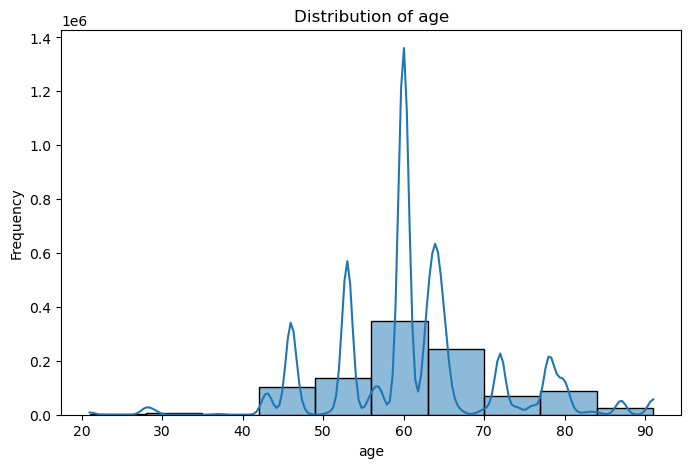

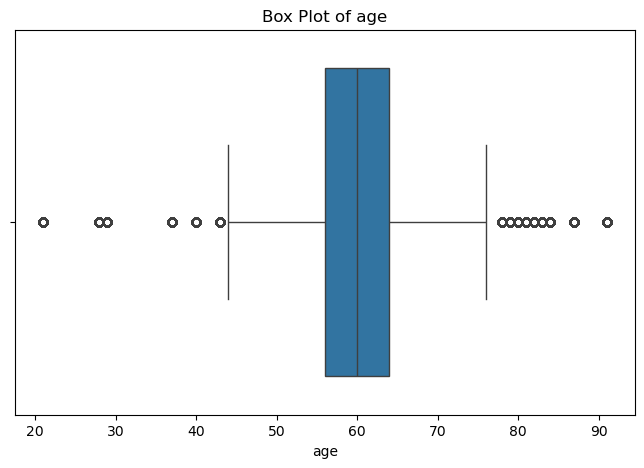

In [ ]:
univariate_analysis(cleaned_data, 'age')

* The summary statistics for age reveal that the dataset spans a wide range of ages, with an average of approximately 61.37 years. The minimum recorded age is 21 years, while the maximum age reaches 91 years. The standard deviation of around 10.23 indicates variability in age distribution. Additionally, the 25th percentile corresponds to 56 years, the median (50th percentile) is 60 years, and the 75th percentile falls at 64 years. In summary, the dataset exhibits diverse age groups, with a central tendency around 60 years.
* the box plot indicates,the median age (Q2) is approximately 60 years, and the spread from Q1 (around 56 years) to Q3 (approximately 64 years) indicates moderate variability. Potential outliers exist beyond the whiskers, with ages ranging from 21 to 91 years. In summary, this plot visually summarizes age distribution. 



#### 2. length_of_stay

Summary statistics for length_of_stay:
count    1.025833e+06
mean     6.281938e+00
std      7.195579e+00
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      4.400000e+01
Name: length_of_stay, dtype: float64



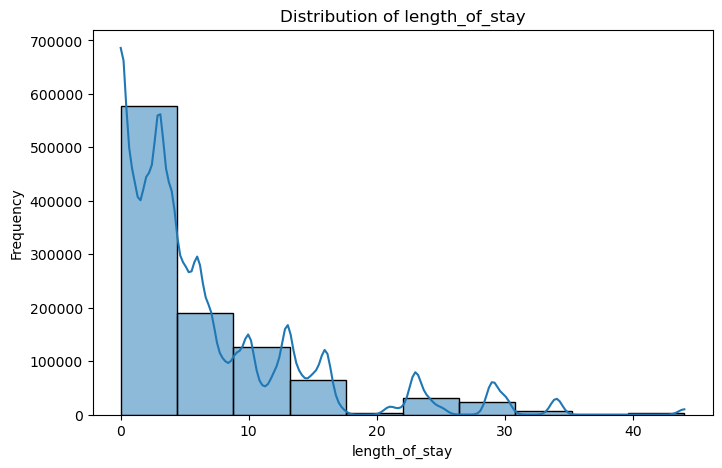

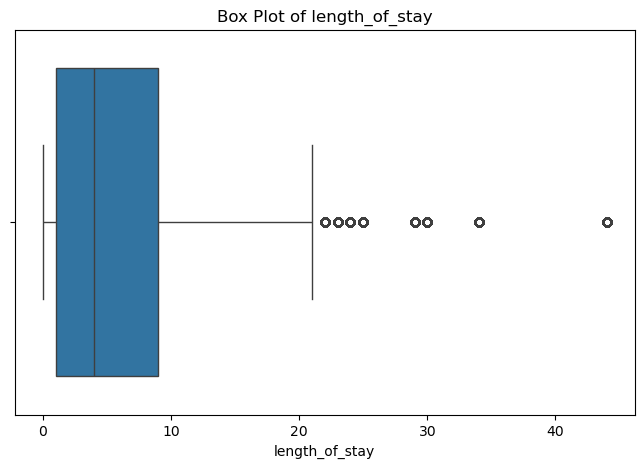

In [ ]:
univariate_analysis(cleaned_data, 'length_of_stay')

* The "Distribution of length_of_stay" histogram presented is right-skewed. The average length of stay is approximately 6.28 days, with considerable variability (standard deviation around 7.2). The dataset includes stays as short as 0 days (likely same-day discharges) and as long as 44 days. Most stays fall within the range of 1 to 9 days. In summary, shorter stays are more common, but there is a wide distribution of lengths.
* The box plot shows the median length of stay (around 3-4 days) and significant variability. Outliers on the right side indicate much longer stays. In summary, this visualization highlights both central tendencies and extreme values

### b) Bivariate Analysis

Used to investigate the relationship between two variables.

Lets start with a contingency table that shows the frequency distribution of variables

#### 1. Admission type vs Died


In [ ]:
# Crosstab for Admission Type vs Died
contingency_table = pd.crosstab(cleaned_data['admission_type'], cleaned_data['died'])
print(contingency_table)


died                          False  True 
admission_type                            
AMBULATORY OBSERVATION        19153   3960
DIRECT EMER.                  52679  16893
DIRECT OBSERVATION            20731      0
ELECTIVE                      35998   7920
EU OBSERVATION               150520      0
EW EMER.                     305345  19227
OBSERVATION ADMIT            265887  14168
SURGICAL SAME DAY ADMISSION   19102   1053
URGENT                        83346   9851


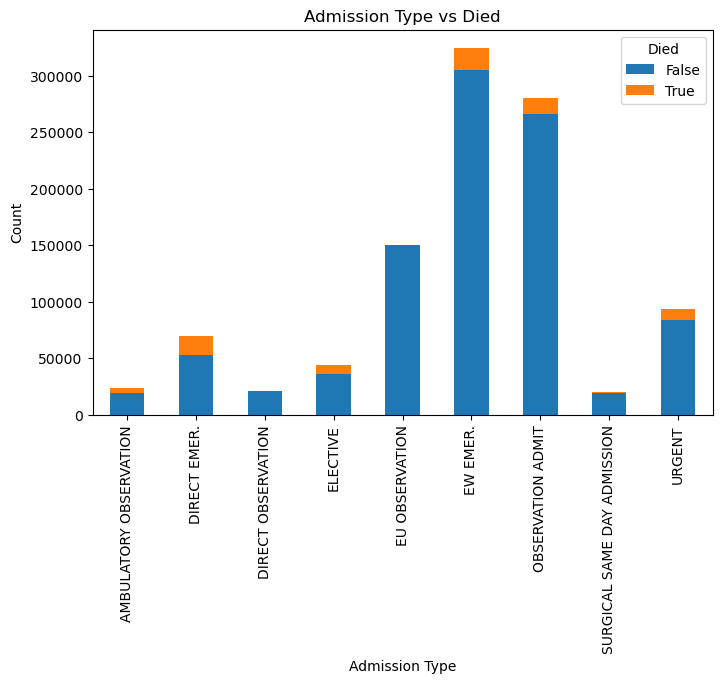

In [ ]:
# Stacked bar plot for Admission Type vs Died
contingency_table.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Admission Type vs Died')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.legend(title='Died')
plt.show()


The chart indeed indicates that admission types such as EW EMER. and OBSERVATION ADMIT have higher overall patient counts, with a noticeable proportion of deaths. In contrast, admission types like SURGICAL SAME DAY ADMISSION and DIRECT OBSERVATION have lower overall counts and fewer associated deaths. This suggests potential correlations between admission type and mortality rates, with certain admission types possibly indicating higher risks.

In [ ]:
#creating a function for Bivariate analysis
def bivariate_categorical_countplot(df, cat_var1, cat_var2):
    """
    Perform bivariate analysis for two categorical features using a count plot.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    cat_var1 (str): The first categorical variable.
    cat_var2 (str): The second categorical variable.
    """
    
    plt.figure(figsize=(10, 6))
    sns.countplot(data=cleaned_data, x=cat_var1, hue=cat_var2, palette='Set1')
    plt.title(f'{cat_var1} vs. {cat_var2}')
    plt.xlabel(cat_var1)
    plt.ylabel('Count')
    plt.legend(title=cat_var2)
    plt.show()


#### 2. Gender vs Died

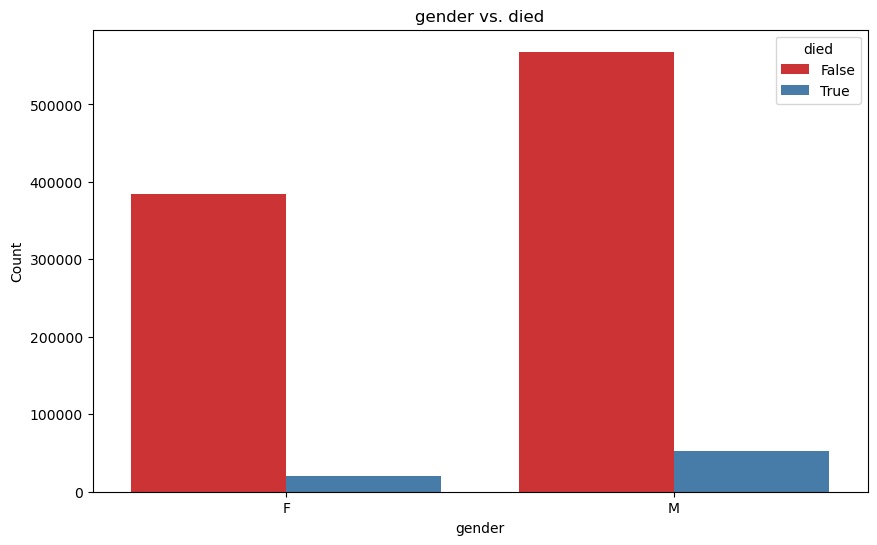

In [ ]:

bivariate_categorical_countplot(cleaned_data, 'gender', 'died')

The bar chart illustrates a higher mortality rate among male patients compared to female patients.

#### 3. Marital vs Died

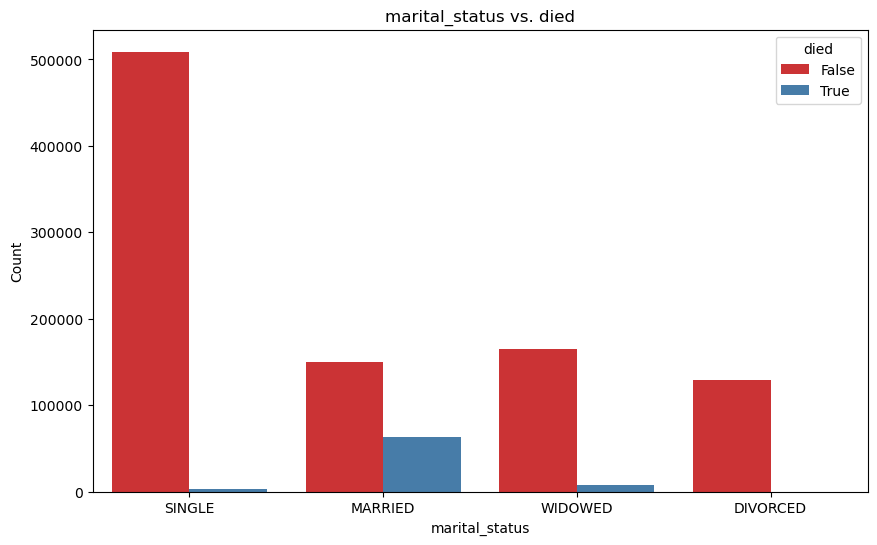

In [ ]:
bivariate_categorical_countplot(cleaned_data, 'marital_status', 'died')

The bar chart illustrates that married individuals have the highest count, followed by widowed, divorced, and single individuals, with a disproportionately higher number of deaths among single individuals relative to their population size.

#### 4. Age vs Length of stay

In [ ]:
cleaned_data.age

0          71
1          71
2          71
3          71
4          71
           ..
2362332    60
2362333    60
2362334    60
2362335    60
2362336    60
Name: age, Length: 1025833, dtype: int64

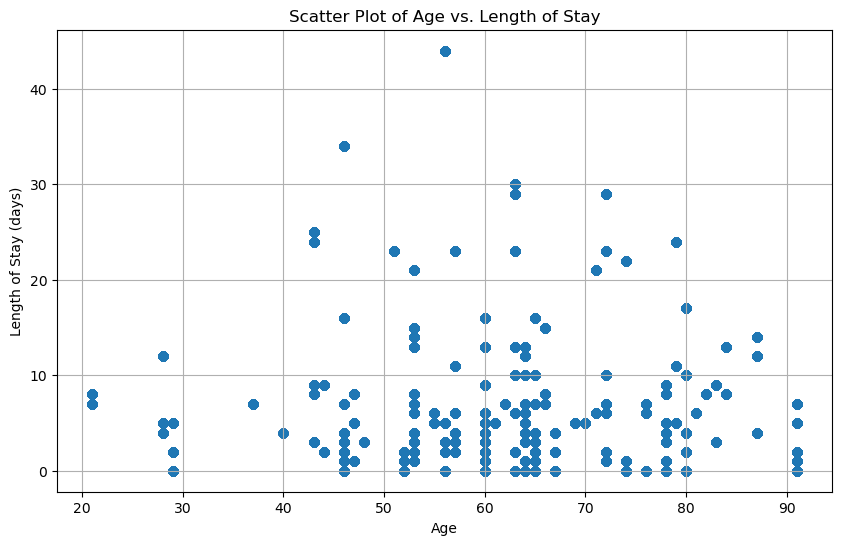

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['age'], cleaned_data['length_of_stay'], alpha=0.5)
plt.title('Scatter Plot of Age vs. Length of Stay')
plt.xlabel('Age')
plt.ylabel('Length of Stay (days)')
plt.grid(True)
plt.show()


The scatter plot indicates a weak or no correlation between age and length of stay. There is a wide range of lengths of stay for each age group, suggesting that factors other than age primarily influence the duration of hospitalization.

#### 5. Length of stay vs Marital status

<Figure size 1200x600 with 0 Axes>

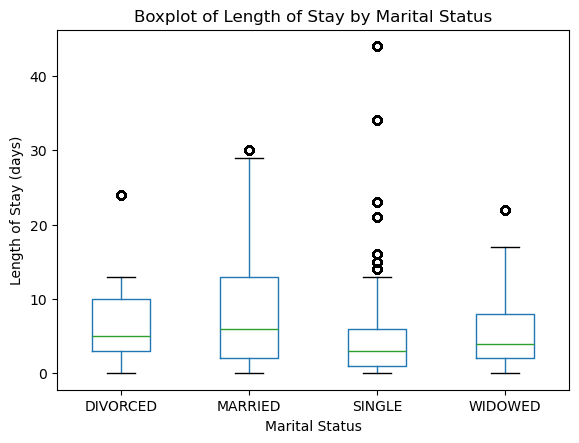

In [ ]:
plt.figure(figsize=(12, 6))
cleaned_data.boxplot(column='length_of_stay', by='marital_status', grid=False)
plt.title('Boxplot of Length of Stay by Marital Status')
plt.suptitle('')  # Suppresses the automatic title to make the plot cleaner
plt.xlabel('Marital Status')
plt.ylabel('Length of Stay (days)')
plt.show()


Married individuals tend to have longer hospital stays compared to divorced, single, and widowed individuals. Additionally, there are outliers in most groups, indicating some patients with exceptionally long hospital stays regardless of marital status. Furthermore, there is greater variability in the length of stay among divorced and widowed individuals.

### Time Series

This visualization provides a high-level overview of the trends in hospital admissions over time, allowing for quick identification of patterns, seasonality, and any significant changes in admission rates. This can help healthcare professionals and decision-makers understand the overall healthcare system performance and make informed decisions about resource allocation and patient care.

#### 1. Monthly Mean Admissions

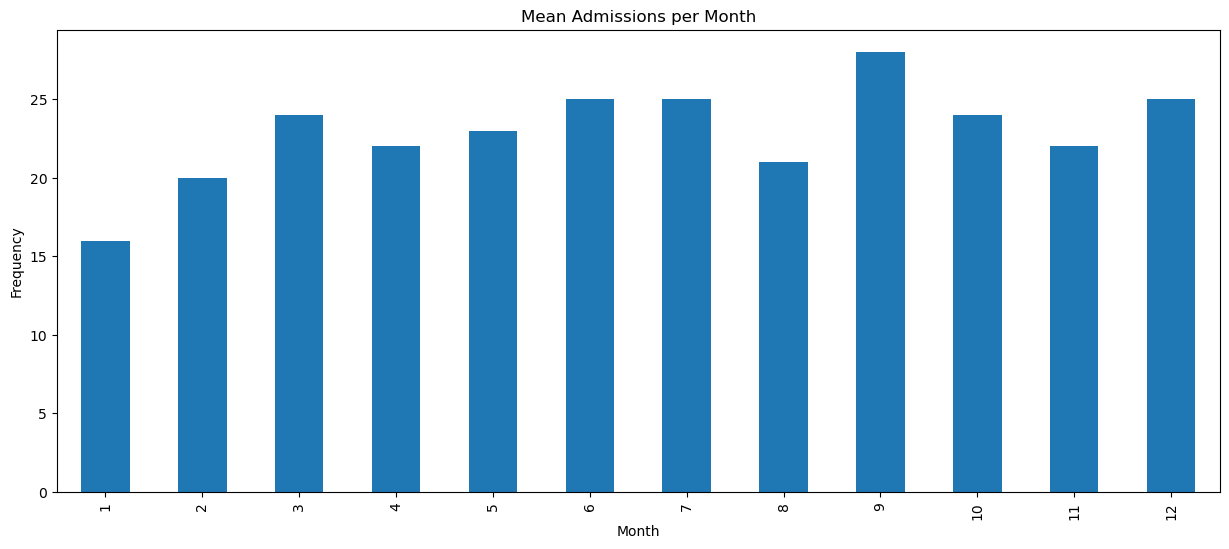

In [ ]:
admissions_copy = base_df.copy()
# plot mean admissions per month
admissions_copy["month"] = pd.to_datetime(admissions_copy["admittime"]).dt.month
admissions_copy.groupby("month")["hadm_id"].count().plot(kind='bar', figsize=(15, 6))
plt.title('Mean Admissions per Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

From the chart, it is evident that September (month 9) has the highest mean admissions, while January (month 1) has the lowest. The other months show varying levels of admissions, with generally higher numbers in the middle of the year.

#### 2. Total Monthly Readmissions

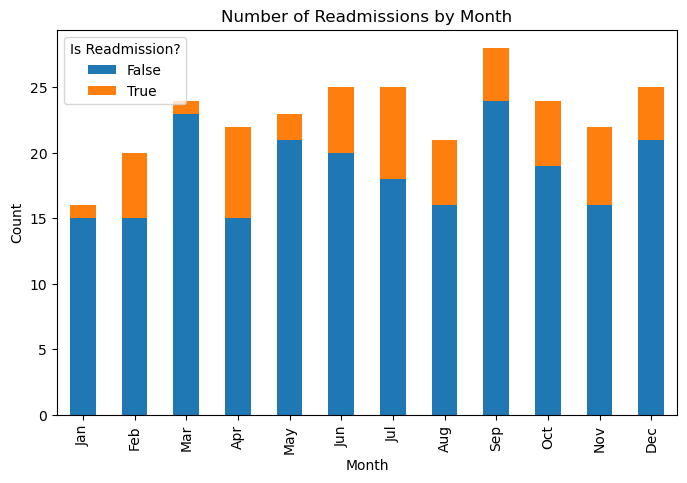

In [ ]:
readmissions_month = readmissions_df.copy()
readmissions_month['admittime_month'] = pd.to_datetime(readmissions_month['admittime']).dt.month
readmissions_month.groupby('admittime_month')['is_readmission'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(8, 5))

# list of month names
months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#  locations for  months
month_locations = [i for i in range(12)]

plt.title('Number of Readmissions by Month')
plt.xlabel('Month')
plt.xticks(ticks = month_locations, labels = months)
plt.ylabel('Count')
plt.legend(title='Is Readmission?')

WE can observe that September has the highest total admissions, with a significant portion being readmissions. March also has a high count of readmissions relative to initial admissions. The other months show varying levels of admissions and readmissions, with some months like July and December having relatively fewer readmissions compared to others.

#### 3. Length of stay

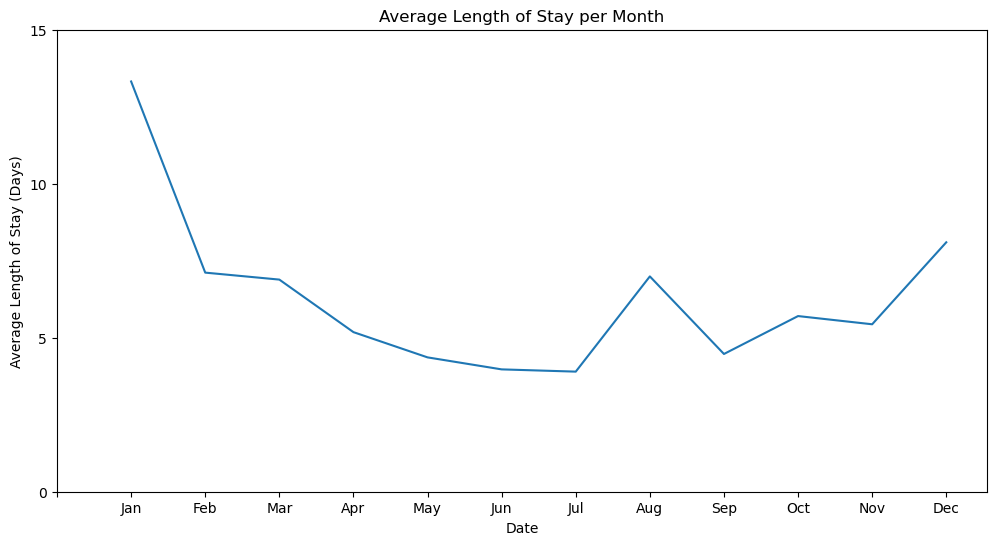

In [ ]:
# find average length of stay per month in length_of_stay_df
average_length_of_stay = length_of_stay_df.groupby(length_of_stay_df.admittime.dt.month)['length_of_stay'].mean()
average_length_of_stay

# Plot the time series for length of stay
average_length_of_stay.plot(figsize=(12, 6), title='Average Length of Stay per Month')
tick_locations = [0, 5, 10, 15]
# Set the labels for these ticks
tick_labels = ['0', '5', '10', '15']

# list of month names
months = [ ' ', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#  locations for  months
month_locations = [i for i in range(13)]

# Apply the yticks
plt.yticks(ticks=tick_locations, labels=tick_labels)
plt.xticks(ticks = month_locations, labels = months)
plt.xlabel('Date')
plt.ylabel('Average Length of Stay (Days)')
plt.show()

Key observations:

The average length of stay is highest in January, starting at around 14 days.
There is a steep decline from January to February, followed by a gradual decline until July.
From August onwards, the length of stay fluctuates slightly, with minor peaks in August and November, before ending with an increase in December.
Overall, the chart shows a downward trend in the average length of stay during the first half of the year, with some fluctuations in the latter months.


#### 4. Top mostly prescribed drugs per month

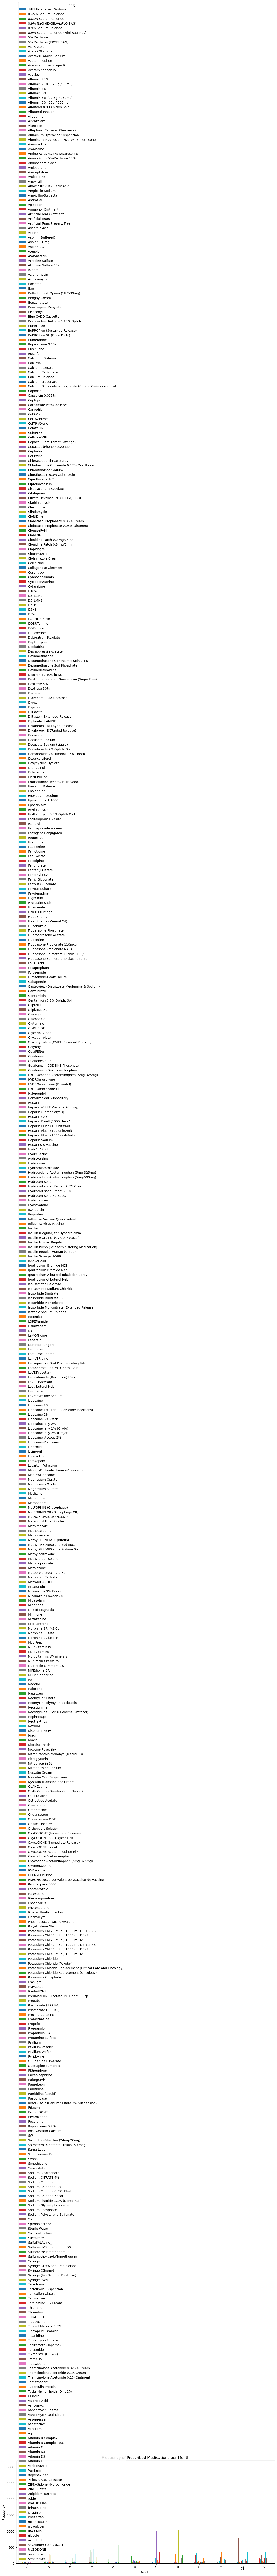

In [ ]:
prescription_copy = cleaned_data.copy()
prescription_copy["month"] = pd.to_datetime(prescription_copy["admittime"]).dt.month
#for every month, count the frequency of prescribed medications
month_freq = prescription_copy.groupby("month")["drug"].value_counts().unstack().fillna(0)
month_freq.plot(kind='bar', figsize=(15, 6))
plt.title('Frequency of Prescribed Medications per Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

The bottom graph indicates how often each drug is used or distributed, with peaks likely representing higher usage rates.
The colors help to distinguish between different drugs and make it easier to track trends or outliers.

This visualization is particularly useful for a detailed, granular analysis, where understanding the distribution and frequency of many different drugs is crucial. The color-coding and comprehensive listing make it possible to differentiate between numerous drugs, even in a densely packed dataset.

The mostly used drug each month is sodium chloride.

## Evaluation

**Length of stay:**
Predicting the length of stay proved to be a very challenging task. Numerous model were tried, but none would outperform the base linear regressor. Eventually the random forest regressor proved up to the challenge outperforming all other models even without any parameter tuning. With a relatively low mean absolute error of 0.23 and an R-squared of 78%, the model is fairly accurate with its predictions on average. As such it was chosen to predict the length of stay target variable.

**Death:** Predicting the death variable wound up being straight forward as the first model tried (logistic regression) was verry effective at the classification. With a 97% accuracy, the model incredibly accurate despite the massive class imbalance.

**Readmission:** Given the logistic regression's succes at predicting the death variable it was tried again for predicting readmission possibilities. The model proved fsirli accurate with an accuracy score of 82%. A random forest classifier was then tried and tuned with a grid search which proved marginally better with an accuracy of 84%. It is particularly strong at classifying class 0 with an f1 score of 0.88. It was the model chosen to predict the readmission variable.

## Conclusion

The team accomplished what we set out to do. Multiple models were created to predict the various target variables and they all performed well or excellently. The information that the models provide to hospital administrators can be invaluable for resource allocation and planning. The models can be interacted with on the website we created to get a better ideo of the impact that they can have.